# Working with 3rd party (detached) Prompts/Prompt Template Assets


This notebook should be run using with Runtime 22.2 & Python 3.10 or greater runtime environment, if you are viewing this in Watson Studio, and do not see Python 3.10.x in the upper right corner of your screen, please update the runtime now. 

The notebook will create a summarization prompt template asset in a given project, configure OpenScale to monitor that PTA and evaluate generative quality metrics and model health metrics.

If users wish to execute this notebook for task types other than summarization, please consult [this](https://github.com/IBM/watson-openscale-samples/blob/main/IBM%20Cloud/WML/notebooks/watsonx/README.md) document for guidance on evaluating prompt templates for the available task types.

Note : User can search for `EDIT THIS` and fill the inputs needed.

## Prerequisite

* It requires service credentials for IBM Watson OpenScale:
* Requires a CSV file containing the test data that needs to be evaluated
* Requires the ID of project in which you want to create the prompt template asset.

### Contents

- [Setup](#settingup)
- [Create Prompt template](#prompt)
- [Prompt Setup](#ptatsetup)
- [Risk evaluations for prompt template asset subscription](#evaluate)
- [Display the Model Risk metrics](#mrmmetric)
- [Display the Generative AI Quality metrics](#genaimetrics)
- [Plot rougel and rougelsum metrics against records](#plotproject)
- [See factsheets information](#factsheetsspace)

## Setup <a name="settingup"></a>

In [ ]:
!pip install --upgrade datasets==2.10.0 --no-cache | tail -n 1
!pip install --upgrade evaluate --no-cache | tail -n 1
!pip install --upgrade --extra-index-url https://test.pypi.org/simple/ ibm-aigov-facts-client | tail -n 1
!pip install --upgrade ibm-watson-openscale | tail -n 1
!pip install --upgrade matplotlib | tail -n 1
!pip install --upgrade pydantic==1.10.11 --no-cache | tail -n 1
!pip install --upgrade sacrebleu --no-cache | tail -n 1
!pip install --upgrade sacremoses --no-cache | tail -n 1
!pip install --upgrade textstat --no-cache | tail -n 1
!pip install --upgrade transformers --no-cache | tail -n 1

Note: you may need to restart the kernel to use updated packages.

### Provision services and configure credentials

If you have not already, provision an instance of IBM Watson OpenScale using the [OpenScale link in the Cloud catalog](https://cloud.ibm.com/catalog/services/watson-openscale).

Your Cloud API key can be generated by going to the [**Users** section of the Cloud console](https://cloud.ibm.com/iam#/users). From that page, click your name, scroll down to the **API Keys** section, and click **Create an IBM Cloud API key**. Give your key a name and click **Create**, then copy the created key and paste it below.

**NOTE:** You can also get OpenScale `API_KEY` using IBM CLOUD CLI.

How to install IBM Cloud (bluemix) console: [instruction](https://console.bluemix.net/docs/cli/reference/ibmcloud/download_cli.html#install_use)

How to get api key using console:
```
bx login --sso
bx iam api-key-create 'my_key'
```

In [2]:
use_cpd = False

if use_cpd:
    CPD_URL = "<EDIT THIS>"
    CPD_USERNAME = "<EDIT THIS>"
    CPD_PASSWORD = "<EDIT THIS>"
    WOS_SERVICE_INSTANCE_ID = "<EDIT THIS>"  # If None, default instance would be used
else:
    IAM_URL = "https://iam.cloud.ibm.com"
    DATAPLATFORM_URL = "https://api.dataplatform.cloud.ibm.com"
    SERVICE_URL = "https://aiopenscale.cloud.ibm.com"
    CLOUD_API_KEY = "<EDIT THIS>"  # YOUR_CLOUD_API_KEY

## Set the project ID

In order to set up a development type subscription, the PTA must be within the project. Please supply the project ID where the PTA needs to be created.

In [3]:
PROJECT_ID = "<EDIT THIS>"  # YOUR_PROJECT_ID

## Function to create the access token

This function generates an IAM access token using the provided credentials. The API calls for creating and scoring prompt template assets utilize the token generated by this function.

In [4]:
import requests, json


def generate_access_token():
    headers = {}
    if not use_cpd:
        headers["Content-Type"] = "application/x-www-form-urlencoded"
        headers["Accept"] = "application/json"
        data = {
            "grant_type": "urn:ibm:params:oauth:grant-type:apikey",
            "apikey": CLOUD_API_KEY,
            "response_type": "cloud_iam"
        }
        response = requests.post(IAM_URL + "/identity/token", data=data, headers=headers)
        json_data = response.json()
        iam_access_token = json_data["access_token"]
    else:
        headers["Content-Type"] = "application/json"
        headers["Accept"] = "application/json"
        data = {
            "username": CPD_USERNAME,
            "password": CPD_PASSWORD
        }
        data = json.dumps(data).encode("utf-8")
        url = CPD_URL + "/icp4d-api/v1/authorize"
        response = requests.post(url=url, data=data, headers=headers, verify=False)
        json_data = response.json()
        iam_access_token = json_data["token"]

    return iam_access_token


iam_access_token = generate_access_token()

# HuggingFace model

In [5]:
from transformers import pipeline

summarizer = pipeline(
    "summarization",
    model="google/flan-t5-base",
    tokenizer="google/flan-t5-base"
)

config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

In [6]:
# Download summarisation data
!rm summarisation.csv
!wget https://raw.githubusercontent.com/IBM/watson-openscale-samples/main/IBM%20Cloud/WML/assets/data/summarization/summarisation.csv

--2024-11-05 13:31:09--  https://raw.githubusercontent.com/IBM/watson-openscale-samples/main/IBM%20Cloud/WML/assets/data/summarization/summarisation.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 27115 (26K) [text/plain]
Saving to: ‘summarisation.csv’

summarisation.csv   100%[===================>]  26.48K  --.-KB/s    in 0s      

2024-11-05 13:31:09 (55.8 MB/s) - ‘summarisation.csv’ saved [27115/27115]



In [7]:
import pandas as pd

test_data_path = "summarisation.csv"
llm_data = pd.read_csv(test_data_path)
llm_data.head()

,doc,id,original_text,reference_summary,title,uid
0,Pokemon GO Terms of Service,57866df76cca83a54c0035a1,by using our services you are agreeing to thes...,by playing this game you agree to these terms....,Agreement To Terms,legalsum02
1,Pokemon GO Terms of Service,5786730a6cca83a54c0035b6,if you want to use certain features of the ser...,you have to use google pokemon trainer club or...,Eligibility and Account Registration,legalsum03
2,Pokemon GO Terms of Service,57866df76cca83a54c0035a0,during game play please be aware of your surro...,don t die or hurt others and if you do it s no...,Safe Play,legalsum04
3,Pokemon GO Terms of Service,57866df76cca83a54c00359f,subject to your compliance with these terms ni...,don t copy modify resell distribute or reverse...,Rights in App,legalsum05
4,Pokemon GO Terms of Service,57866df76cca83a54c00359e,for purposes of these terms a content means th...,we grant you full ownership of your user conte...,Content and Content Rights,legalsum06


## Set the generated_summary with the summary from HF Google Flan model prompt evaluation

In [8]:
def get_completion(prompt_text):
    summary = (summarizer(prompt_text, max_length=len(prompt_text), min_length=1))
    summary_text = summary[0]["summary_text"]
    return summary_text

llm_data["generated_text"] = llm_data["original_text"].apply(get_completion)
llm_data.head()

Your max_length is set to 450, but your input_length is only 101. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Token indices sequence length is longer than the specified maximum sequence length for this model (705 > 512). Running this sequence through the model will result in indexing errors
Your max_length is set to 3180, but your input_length is only 705. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=352)
Your max_length is set to 1935, but your input_length is only 387. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=193)
Your max_length is set to 3721, but your input_length is only 75

,doc,id,original_text,reference_summary,title,uid,generated_text
0,Pokemon GO Terms of Service,57866df76cca83a54c0035a1,by using our services you are agreeing to thes...,by playing this game you agree to these terms....,Agreement To Terms,legalsum02,Use our services if you are the parent or lega...
1,Pokemon GO Terms of Service,5786730a6cca83a54c0035b6,if you want to use certain features of the ser...,you have to use google pokemon trainer club or...,Eligibility and Account Registration,legalsum03,Create an account with us. Register for an acc...
2,Pokemon GO Terms of Service,57866df76cca83a54c0035a0,during game play please be aware of your surro...,don t die or hurt others and if you do it s no...,Safe Play,legalsum04,Be aware of your surroundings
3,Pokemon GO Terms of Service,57866df76cca83a54c00359f,subject to your compliance with these terms ni...,don t copy modify resell distribute or reverse...,Rights in App,legalsum05,niantic grants you a limited nonexclusive nont...
4,Pokemon GO Terms of Service,57866df76cca83a54c00359e,for purposes of these terms a content means th...,we grant you full ownership of your user conte...,Content and Content Rights,legalsum06,niniantic grants you a personal noncommercial ...


# Create Prompt template <a name="prompt"></a>

Create a prompt template for a summarization task

In [9]:
from ibm_aigov_facts_client import AIGovFactsClient

if not use_cpd:
    facts_client = AIGovFactsClient(
        api_key=CLOUD_API_KEY,
        container_id=PROJECT_ID,
        container_type="project",
        disable_tracing=True
    )
else:
    from ibm_aigov_facts_client import CloudPakforDataConfig

    creds = CloudPakforDataConfig(
        service_url=CPD_URL,
        username=CPD_USERNAME,
        password=CPD_PASSWORD
    )
    facts_client = AIGovFactsClient(
        cloud_pak_for_data_configs=creds,
        container_id=PROJECT_ID,
        container_type="project",
        disable_tracing=True
    )

In [10]:
from ibm_aigov_facts_client import DetachedPromptTemplate, PromptTemplate

detached_information = DetachedPromptTemplate(
    prompt_id="detached_prompt",
    model_id="google/flan-t5-base",
    model_provider="Hugging Face",
    model_name="google/flan-t5-base",
    model_url="https://huggingface.co/google/flan-t5-base",
    prompt_url="prompt_url",
    prompt_additional_info={"model_owner": "huggingface"}
)

task_id = "summarization"
name = "External prompt sample (google/flan-t5-base HF)"
description = "My first detached prompt"
model_id = "google/flan-t5-base"

# define parameters for PromptTemplate
prompt_variables = {"original_text": ""}
input = "{original_text}"
input_prefix = "Input:"
output_prefix = "Output:"

prompt_template = PromptTemplate(
    input=input,
    prompt_variables=prompt_variables,
    input_prefix=input_prefix,
    output_prefix=output_prefix
)

pta_details = facts_client.assets.create_detached_prompt(
    model_id=model_id,
    task_id=task_id,
    name=name,
    description=description,
    prompt_details=prompt_template,
    detached_information=detached_information
)
project_pta_id = pta_details.to_dict()["asset_id"]

2024/11/05 13:38:43 INFO : ------------------------------ Detached Prompt Creation Started ------------------------------
2024/11/05 13:38:45 INFO : The detached prompt with ID 62601dc6-c2c5-411e-8f15-dbe6e5f87914 was created successfully in container_id 92a5f3ed-2c64-4039-817c-030404d1f2be.


# Prompt setup <a name="ptatsetup"></a>

### Configure OpenScale

In [11]:
from ibm_cloud_sdk_core.authenticators import IAMAuthenticator, CloudPakForDataAuthenticator

from ibm_watson_openscale import *
from ibm_watson_openscale.supporting_classes.enums import *
from ibm_watson_openscale.supporting_classes import *

if use_cpd:
    authenticator = CloudPakForDataAuthenticator(
        url=CPD_URL,
        username=CPD_USERNAME,
        password=CPD_PASSWORD,
        disable_ssl_verification=True
    )
    wos_client = APIClient(
        service_url=CPD_URL,
        authenticator=authenticator,
        service_instance_id=WOS_SERVICE_INSTANCE_ID
    )
    data_mart_id = wos_client.service_instance_id
    print(wos_client.version)
else:
    service_instance_id = None  # Update this to refer to a particular service instance
    authenticator = IAMAuthenticator(
        apikey=CLOUD_API_KEY,
        url=IAM_URL
    )
    wos_client = APIClient(
        authenticator=authenticator,
        service_url=SERVICE_URL,
        service_instance_id=service_instance_id
    )
    data_mart_id = wos_client.service_instance_id
    print(wos_client.version)

3.0.41


### Openscale instance mapping with the project

When the authentication is on CPD then we need to add additional step of mapping the project_id/space_id to an OpenScale instance.

In [13]:
from ibm_watson_openscale.base_classes import ApiRequestFailure

if use_cpd:
    try:
        wos_client.wos.add_instance_mapping(
            service_instance_id=data_mart_id,
            project_id=PROJECT_ID
        )
    except ApiRequestFailure as arf:
        if arf.response.status_code == 409:
            # Instance mapping already exists
            pass
        else:
            raise arf

### Setup the prompt template asset in project for evaluation with supported monitor dimensions

The prompt template assets from project is only supported with `development` operational space ID. Running the below cell will create a development type subscription from the prompt template asset created within the project.

The available parameters that can be passed for `execute_prompt_setup` function are:

 * `prompt_template_asset_id` : Id of prompt template asset for which subscription needs to be created.
 * `label_column` :  The name of the column containing the ground truth or actual labels.
 * `project_id` : The GUID of the project.
 * `space_id` : The GUID of the space.
 * `deployment_id` : (optional) The GUID of the deployment.
 * `operational_space_id` : The rank of the environment in which the monitoring is happening. Accepted values are `development`, `pre_production`, `production`.
 * `problem_type` : (optional) The task type to monitor for the given prompt template asset.
 * `classification_type` : The classification type `binary`/`multiclass` applicable only for `classification` problem (task) type.
 * `input_data_type` : The input data type.
 * `supporting_monitors` : Monitor configuration for the subscription to be created.
 * `background_mode` : When `True`, the promt setup operation will be executed in the background

In [14]:
label_column = "reference_summary"
operational_space_id = "development"
problem_type = "summarization"
input_data_type = "unstructured_text"

monitors = {
    "generative_ai_quality": {
        "parameters": {
            "min_sample_size": 10,
            "metrics_configuration": {
            }
        }
    }
}

response = wos_client.wos.execute_prompt_setup(
    prompt_template_asset_id=project_pta_id,
    project_id=PROJECT_ID,
    label_column=label_column,
    operational_space_id=operational_space_id,
    problem_type=problem_type,
    input_data_type=input_data_type,
    supporting_monitors=monitors,
    background_mode=False
)

result = response.result
result.to_dict()




 Waiting for end of adding prompt setup 62601dc6-c2c5-411e-8f15-dbe6e5f87914 




running.
finished

---------------------------------------------------------------
 Successfully finished setting up prompt template subscription 
---------------------------------------------------------------




{'prompt_template_asset_id': '62601dc6-c2c5-411e-8f15-dbe6e5f87914',
 'project_id': '92a5f3ed-2c64-4039-817c-030404d1f2be',
 'deployment_id': '4a88635f-e726-45ec-8592-3cf1ab87da99',
 'service_provider_id': 'c140464e-7339-48f6-8885-267635896e16',
 'subscription_id': '654ef1f1-d297-4cf6-a144-55d1d851caad',
 'mrm_monitor_instance_id': 'e623c7a5-e560-4dbc-a9c7-e63a99ad34ff',
 'start_time': '2024-11-05T13:39:48.918946Z',
 'end_time': '2024-11-05T13:40:02.005810Z',
 'status': {'state': 'FINISHED'}}

With the below cell, users can  read the  prompt setup task and check its status

In [15]:
response = wos_client.wos.get_prompt_setup(
    prompt_template_asset_id=project_pta_id,
    project_id=PROJECT_ID
)

result = response.result
result_json = result.to_dict()

if result_json["status"]["state"] == "FINISHED":
    print("Finished prompt setup. The response is {}".format(result_json))
else:
    print("Prompt setup failed. The response is {}".format(result_json))

Finished prompt setup. The response is {'prompt_template_asset_id': '62601dc6-c2c5-411e-8f15-dbe6e5f87914', 'project_id': '92a5f3ed-2c64-4039-817c-030404d1f2be', 'deployment_id': '4a88635f-e726-45ec-8592-3cf1ab87da99', 'service_provider_id': 'c140464e-7339-48f6-8885-267635896e16', 'subscription_id': '654ef1f1-d297-4cf6-a144-55d1d851caad', 'mrm_monitor_instance_id': 'e623c7a5-e560-4dbc-a9c7-e63a99ad34ff', 'start_time': '2024-11-05T13:39:48.918946Z', 'end_time': '2024-11-05T13:40:02.005810Z', 'status': {'state': 'FINISHED'}}


### Read required IDs from prompt setup response

In [16]:
subscription_id = result_json["subscription_id"]
mrm_monitor_instance_id = result_json["mrm_monitor_instance_id"]

## Show all the monitor instances of the production subscription
The following cell lists the monitors present in the development subscription along with their respective statuses and other details. Please wait for all the monitors to be in active state before proceeding further.

In [17]:
wos_client.monitor_instances.show(target_target_id=subscription_id)

99c303f8-46bb-4812-9ab3-380d40de9233,active,654ef1f1-d297-4cf6-a144-55d1d851caad,subscription,generative_ai_quality,2024-11-05 13:39:53.833000+00:00,59816f85-bbe5-460e-9a4e-af29a4c0bd25
99c303f8-46bb-4812-9ab3-380d40de9233,active,654ef1f1-d297-4cf6-a144-55d1d851caad,subscription,model_health,2024-11-05 13:39:55.227000+00:00,edd4a56c-68c1-44c3-b8df-bdef31e1fdb5
99c303f8-46bb-4812-9ab3-380d40de9233,active,654ef1f1-d297-4cf6-a144-55d1d851caad,subscription,mrm,2024-11-05 13:39:56.267000+00:00,e623c7a5-e560-4dbc-a9c7-e63a99ad34ff


# Risk evaluations for PTA subscription <a name="evaluate"></a>

### Evaluate the prompt template subscription

For the risk assessment of a development type subscription the user needs to have an evaluation dataset. The risk evaluation function takes the evaluation dataset path as a parameter for evaluation of the configured metric dimensions. If there is a discrepancy between the feature columns in the subscription and the column names in the uploading CSV, users has the option to supply a mapping JSON file to associate the CSV column names with the feature column names in the subscription.


**Note:* If you are running this notebook from Watson studio, you may first need to upload your test data to studio and run code snippet to download feedback data file from project to local directory

The following cell will assess the test data with the subscription of the prompt template asset and produce relevant measurements for the configured monitor.

In [18]:
test_data_set_name = "data"
content_type = "multipart/form-data"
body = {}

# Preparing the test data, removing extra columns
cols_to_remove = ["uid", "doc", "title", "id"]
for col in cols_to_remove:
    if col in llm_data:
        del llm_data[col]
llm_data.to_csv(test_data_path, index=False)

response = wos_client.monitor_instances.mrm.evaluate_risk(
    monitor_instance_id=mrm_monitor_instance_id,
    test_data_set_name=test_data_set_name,
    test_data_path=test_data_path,
    content_type=content_type,
    body=body,
    project_id=PROJECT_ID,
    includes_model_output=True,
    background_mode=False
)




 Waiting for risk evaluation of MRM monitor e623c7a5-e560-4dbc-a9c7-e63a99ad34ff 




upload_in_progress
running...
finished

---------------------------------------
 Successfully finished evaluating risk 
---------------------------------------




### Read the risk evaluation response

After initiating the risk evaluation, the evaluation results are now available for review

In [ ]:
response = wos_client.monitor_instances.mrm.get_risk_evaluation(mrm_monitor_instance_id, project_id=PROJECT_ID)
response.result.to_dict()

# Display the Model Risk metrics <a name="mrmmetric"></a>

Having calculated the measurements for the Foundation Model subscription, the MRM metrics generated for this subscription are now available for your review.

In [20]:
wos_client.monitor_instances.show_metrics(monitor_instance_id=mrm_monitor_instance_id, project_id=PROJECT_ID)

2024-11-05 13:40:30.552000+00:00,tests_passed,6025803d-eb18-487b-be4c-be504b51e4ca,0.0,None,None,['test_data_set_name:data'],mrm,e623c7a5-e560-4dbc-a9c7-e63a99ad34ff,58ba04b7-165a-40c7-b04c-f1c7979b7af6,subscription,654ef1f1-d297-4cf6-a144-55d1d851caad
2024-11-05 13:40:30.552000+00:00,tests_run,6025803d-eb18-487b-be4c-be504b51e4ca,1.0,None,None,['test_data_set_name:data'],mrm,e623c7a5-e560-4dbc-a9c7-e63a99ad34ff,58ba04b7-165a-40c7-b04c-f1c7979b7af6,subscription,654ef1f1-d297-4cf6-a144-55d1d851caad
2024-11-05 13:40:30.552000+00:00,tests_skipped,6025803d-eb18-487b-be4c-be504b51e4ca,3.0,None,None,['test_data_set_name:data'],mrm,e623c7a5-e560-4dbc-a9c7-e63a99ad34ff,58ba04b7-165a-40c7-b04c-f1c7979b7af6,subscription,654ef1f1-d297-4cf6-a144-55d1d851caad
2024-11-05 13:40:30.552000+00:00,tests_failed,6025803d-eb18-487b-be4c-be504b51e4ca,1.0,None,None,['test_data_set_name:data'],mrm,e623c7a5-e560-4dbc-a9c7-e63a99ad34ff,58ba04b7-165a-40c7-b04c-f1c7979b7af6,subscription,654ef1f1-d297-4cf6-a144-55d1d851caad


# Display the Generative AI Quality metrics <a name="genaimetrics"></a>



Monitor instance ID of Generative ai quality metrics is required for reading its metrics.

In [21]:
monitor_definition_id = "generative_ai_quality"
result = wos_client.monitor_instances.list(
    data_mart_id=data_mart_id,
    monitor_definition_id=monitor_definition_id,
    target_target_id=subscription_id,
    project_id=PROJECT_ID
).result
result_json = result._to_dict()
genaiquality_monitor_id = result_json["monitor_instances"][0]["metadata"]["id"]
genaiquality_monitor_id

'59816f85-bbe5-460e-9a4e-af29a4c0bd25'

Displaying the GenAIQ monitor metrics generated through the risk evaluation.

In [22]:
wos_client.monitor_instances.show_metrics(monitor_instance_id=genaiquality_monitor_id, project_id=PROJECT_ID)

2024-11-05 13:40:46.690740+00:00,flesch_reading_ease,d26b6532-36e1-4d81-9ccf-106ddb55166b,65.183,60.0,None,"['computed_on:feedback', 'field_type:subscription', 'aggregation_type:mean']",generative_ai_quality,59816f85-bbe5-460e-9a4e-af29a4c0bd25,bfb264d2-5fdc-452b-aedf-70452a20dd53,subscription,654ef1f1-d297-4cf6-a144-55d1d851caad
2024-11-05 13:40:46.690740+00:00,normalized_recall,d26b6532-36e1-4d81-9ccf-106ddb55166b,0.1837,0.8,None,"['computed_on:feedback', 'field_type:subscription', 'aggregation_type:mean']",generative_ai_quality,59816f85-bbe5-460e-9a4e-af29a4c0bd25,bfb264d2-5fdc-452b-aedf-70452a20dd53,subscription,654ef1f1-d297-4cf6-a144-55d1d851caad
2024-11-05 13:40:46.690740+00:00,rouge2,d26b6532-36e1-4d81-9ccf-106ddb55166b,0.0247,0.8,None,"['computed_on:feedback', 'field_type:subscription', 'aggregation_type:mean']",generative_ai_quality,59816f85-bbe5-460e-9a4e-af29a4c0bd25,bfb264d2-5fdc-452b-aedf-70452a20dd53,subscription,654ef1f1-d297-4cf6-a144-55d1d851caad
2024-11-05 13:40:46.690740+00:00,records_processed,d26b6532-36e1-4d81-9ccf-106ddb55166b,10.0,None,None,"['computed_on:feedback', 'field_type:subscription', 'aggregation_type:mean']",generative_ai_quality,59816f85-bbe5-460e-9a4e-af29a4c0bd25,bfb264d2-5fdc-452b-aedf-70452a20dd53,subscription,654ef1f1-d297-4cf6-a144-55d1d851caad
2024-11-05 13:40:46.690740+00:00,jaccard_similarity,d26b6532-36e1-4d81-9ccf-106ddb55166b,0.0757,0.8,None,"['computed_on:feedback', 'field_type:subscription', 'aggregation_type:mean']",generative_ai_quality,59816f85-bbe5-460e-9a4e-af29a4c0bd25,bfb264d2-5fdc-452b-aedf-70452a20dd53,subscription,654ef1f1-d297-4cf6-a144-55d1d851caad
2024-11-05 13:40:46.690740+00:00,meteor,d26b6532-36e1-4d81-9ccf-106ddb55166b,0.1305,0.8,None,"['computed_on:feedback', 'field_type:subscription', 'aggregation_type:mean']",generative_ai_quality,59816f85-bbe5-460e-9a4e-af29a4c0bd25,bfb264d2-5fdc-452b-aedf-70452a20dd53,subscription,654ef1f1-d297-4cf6-a144-55d1d851caad
2024-11-05 13:40:46.690740+00:00,rougelsum,d26b6532-36e1-4d81-9ccf-106ddb55166b,0.1089,0.8,None,"['computed_on:feedback', 'field_type:subscription', 'aggregation_type:mean']",generative_ai_quality,59816f85-bbe5-460e-9a4e-af29a4c0bd25,bfb264d2-5fdc-452b-aedf-70452a20dd53,subscription,654ef1f1-d297-4cf6-a144-55d1d851caad
2024-11-05 13:40:46.690740+00:00,normalized_precision,d26b6532-36e1-4d81-9ccf-106ddb55166b,0.1666,0.8,None,"['computed_on:feedback', 'field_type:subscription', 'aggregation_type:mean']",generative_ai_quality,59816f85-bbe5-460e-9a4e-af29a4c0bd25,bfb264d2-5fdc-452b-aedf-70452a20dd53,subscription,654ef1f1-d297-4cf6-a144-55d1d851caad
2024-11-05 13:40:46.690740+00:00,bleu,d26b6532-36e1-4d81-9ccf-106ddb55166b,0.0,0.8,None,"['computed_on:feedback', 'field_type:subscription', 'aggregation_type:mean']",generative_ai_quality,59816f85-bbe5-460e-9a4e-af29a4c0bd25,bfb264d2-5fdc-452b-aedf-70452a20dd53,subscription,654ef1f1-d297-4cf6-a144-55d1d851caad
2024-11-05 13:40:46.690740+00:00,normalized_f1,d26b6532-36e1-4d81-9ccf-106ddb55166b,0.1303,0.8,None,"['computed_on:feedback', 'field_type:subscription', 'aggregation_type:mean']",generative_ai_quality,59816f85-bbe5-460e-9a4e-af29a4c0bd25,bfb264d2-5fdc-452b-aedf-70452a20dd53,subscription,654ef1f1-d297-4cf6-a144-55d1d851caad


Note: First 10 records were displayed.


## Display record level metrics for Generative AI Quality 

Read the dataset id for generative ai quality dataset

In [23]:
result = wos_client.data_sets.list(
    target_target_id=subscription_id,
    target_target_type="subscription",
    type="gen_ai_quality_metrics"
).result

genaiq_dataset_id = result.data_sets[0].metadata.id
genaiq_dataset_id

'ecc9fb1f-d09b-4ee1-9922-752b7468d51b'

Displaying record level metrics for generative ai quality

In [24]:
wos_client.data_sets.show_records(data_set_id=genaiq_dataset_id)

86.03,0.2608695652173913,None,0.0541,None,MRM_96cf9469-7c54-44c3-88d3-f8c6f75da192-0,0.1935483870967742,feedback,2024-11-05T13:40:24.366Z,0.17474954462659378,0.2051,None,None,None,0.375,None,None,0.0,bfb264d2-5fdc-452b-aedf-70452a20dd53,0.30769230769230765,None,None,0.2051,33.91369848315974,0.14814477977408047,None,None,None,0.3077
74.35,0.05128205128205128,None,0.0,None,MRM_96cf9469-7c54-44c3-88d3-f8c6f75da192-1,0.05,feedback,2024-11-05T13:40:24.366Z,0.051150895140664954,0.0833,None,None,None,0.2222222222222222,None,None,0.0,bfb264d2-5fdc-452b-aedf-70452a20dd53,0.08333333333333333,None,None,0.0833,34.083949495641114,0.15097322081225675,None,None,None,0.0833
83.32,0.0,None,0.0,None,MRM_96cf9469-7c54-44c3-88d3-f8c6f75da192-2,0.0,feedback,2024-11-05T13:40:24.366Z,0.0,0.0,None,None,None,0.0,None,None,0.0,bfb264d2-5fdc-452b-aedf-70452a20dd53,0.0,None,None,0.0,33.22384463952611,0.0,None,None,None,0.0
50.2,0.2727272727272727,None,0.0,None,MRM_96cf9469-7c54-44c3-88d3-f8c6f75da192-3,0.03529411764705882,feedback,2024-11-05T13:40:24.366Z,0.13782751091703058,0.0508,None,None,None,0.028037383177570093,None,None,0.0,bfb264d2-5fdc-452b-aedf-70452a20dd53,0.05084745762711864,None,None,0.0508,33.620290360848195,0.13562911939043598,None,None,None,0.0508
34.8,0.4375,None,0.0276,None,MRM_96cf9469-7c54-44c3-88d3-f8c6f75da192-4,0.07692307692307693,feedback,2024-11-05T13:40:24.366Z,0.26986970684039097,0.0952,None,None,None,0.05343511450381679,None,None,0.0,bfb264d2-5fdc-452b-aedf-70452a20dd53,0.09523809523809525,None,None,0.068,34.32122843046947,0.24847228243133973,None,None,None,0.0952
70.13,0.07142857142857142,None,0.0,None,MRM_96cf9469-7c54-44c3-88d3-f8c6f75da192-5,0.03225806451612903,feedback,2024-11-05T13:40:24.366Z,0.05524861878453038,0.0667,None,None,None,0.0625,None,None,0.0,bfb264d2-5fdc-452b-aedf-70452a20dd53,0.06666666666666667,None,None,0.0667,51.763659708946555,0.08349839461958825,None,None,None,0.0667
44.07,0.14,None,0.0278,None,MRM_96cf9469-7c54-44c3-88d3-f8c6f75da192-6,0.10714285714285714,feedback,2024-11-05T13:40:24.366Z,0.1035080252918288,0.1892,None,None,None,0.2916666666666667,None,None,0.0,bfb264d2-5fdc-452b-aedf-70452a20dd53,0.1891891891891892,None,None,0.1622,34.827813661635076,0.10137544167138747,None,None,None,0.1892
52.09,0.3142857142857143,None,0.0123,None,MRM_96cf9469-7c54-44c3-88d3-f8c6f75da192-7,0.10309278350515463,feedback,2024-11-05T13:40:24.366Z,0.19157088122605362,0.1341,None,None,None,0.08527131782945736,None,None,0.0,bfb264d2-5fdc-452b-aedf-70452a20dd53,0.13414634146341464,None,None,0.0976,34.509107192707916,0.30616984439192546,None,None,None,0.1341
57.61,0.038461538461538464,None,0.0,None,MRM_96cf9469-7c54-44c3-88d3-f8c6f75da192-8,0.02564102564102564,feedback,2024-11-05T13:40:24.366Z,0.0662251655629139,0.0426,None,None,None,0.047619047619047616,None,None,0.0,bfb264d2-5fdc-452b-aedf-70452a20dd53,0.0425531914893617,None,None,0.0426,33.87265831197073,0.08130443859701025,None,None,None,0.0426
99.23,0.25,None,0.125,None,MRM_96cf9469-7c54-44c3-88d3-f8c6f75da192-9,0.13333333333333333,feedback,2024-11-05T13:40:24.366Z,0.2545362903225807,0.2222,None,None,None,0.5,None,None,0.0,bfb264d2-5fdc-452b-aedf-70452a20dd53,0.3333333333333333,None,None,0.2222,57.44781940553999,0.3323458151044596,None,None,None,0.3333


# Display the model health metrics <a name="genaimetrics"></a>



Monitor instance ID of model health metrics is required for reading its metrics

In [25]:
monitor_definition_id = "model_health"
result = wos_client.monitor_instances.list(
    data_mart_id=data_mart_id,
    monitor_definition_id=monitor_definition_id,
    target_target_id=subscription_id,
    project_id=PROJECT_ID
).result
result_json = result._to_dict()
model_health_monitor_id = result_json["monitor_instances"][0]["metadata"]["id"]
model_health_monitor_id

'edd4a56c-68c1-44c3-b8df-bdef31e1fdb5'

Displaying the model health metrics generated through the risk evaluation.

In [26]:
wos_client.monitor_instances.show_metrics(monitor_instance_id=model_health_monitor_id, project_id=PROJECT_ID)

2024-11-05 13:40:37.663608+00:00,total_records,5aff42ed-461c-4e37-880c-e31ef629ad34,10.0,None,None,[],model_health,edd4a56c-68c1-44c3-b8df-bdef31e1fdb5,5e948136-6870-4752-b8b1-93445c8fc6af,subscription,654ef1f1-d297-4cf6-a144-55d1d851caad
2024-11-05 13:40:37.663608+00:00,median_input_token_count,5aff42ed-461c-4e37-880c-e31ef629ad34,0.0,None,None,[],model_health,edd4a56c-68c1-44c3-b8df-bdef31e1fdb5,5e948136-6870-4752-b8b1-93445c8fc6af,subscription,654ef1f1-d297-4cf6-a144-55d1d851caad
2024-11-05 13:40:37.663608+00:00,average_output_token_count,5aff42ed-461c-4e37-880c-e31ef629ad34,0.0,None,None,[],model_health,edd4a56c-68c1-44c3-b8df-bdef31e1fdb5,5e948136-6870-4752-b8b1-93445c8fc6af,subscription,654ef1f1-d297-4cf6-a144-55d1d851caad
2024-11-05 13:40:37.663608+00:00,minimum_output_token_count,5aff42ed-461c-4e37-880c-e31ef629ad34,0.0,None,None,[],model_health,edd4a56c-68c1-44c3-b8df-bdef31e1fdb5,5e948136-6870-4752-b8b1-93445c8fc6af,subscription,654ef1f1-d297-4cf6-a144-55d1d851caad
2024-11-05 13:40:37.663608+00:00,users,5aff42ed-461c-4e37-880c-e31ef629ad34,1.0,None,None,[],model_health,edd4a56c-68c1-44c3-b8df-bdef31e1fdb5,5e948136-6870-4752-b8b1-93445c8fc6af,subscription,654ef1f1-d297-4cf6-a144-55d1d851caad
2024-11-05 13:40:37.663608+00:00,total_scoring_requests,5aff42ed-461c-4e37-880c-e31ef629ad34,10.0,None,None,[],model_health,edd4a56c-68c1-44c3-b8df-bdef31e1fdb5,5e948136-6870-4752-b8b1-93445c8fc6af,subscription,654ef1f1-d297-4cf6-a144-55d1d851caad
2024-11-05 13:40:37.663608+00:00,median_records,5aff42ed-461c-4e37-880c-e31ef629ad34,1.0,None,None,[],model_health,edd4a56c-68c1-44c3-b8df-bdef31e1fdb5,5e948136-6870-4752-b8b1-93445c8fc6af,subscription,654ef1f1-d297-4cf6-a144-55d1d851caad
2024-11-05 13:40:37.663608+00:00,average_input_token_count,5aff42ed-461c-4e37-880c-e31ef629ad34,0.0,None,None,[],model_health,edd4a56c-68c1-44c3-b8df-bdef31e1fdb5,5e948136-6870-4752-b8b1-93445c8fc6af,subscription,654ef1f1-d297-4cf6-a144-55d1d851caad
2024-11-05 13:40:37.663608+00:00,maximum_input_token_count,5aff42ed-461c-4e37-880c-e31ef629ad34,0.0,None,None,[],model_health,edd4a56c-68c1-44c3-b8df-bdef31e1fdb5,5e948136-6870-4752-b8b1-93445c8fc6af,subscription,654ef1f1-d297-4cf6-a144-55d1d851caad
2024-11-05 13:40:37.663608+00:00,median_output_token_count,5aff42ed-461c-4e37-880c-e31ef629ad34,0.0,None,None,[],model_health,edd4a56c-68c1-44c3-b8df-bdef31e1fdb5,5e948136-6870-4752-b8b1-93445c8fc6af,subscription,654ef1f1-d297-4cf6-a144-55d1d851caad


Note: First 10 records were displayed.


## Display record level metrics for model health
<br>

Read the dataset id for model health dataset

In [27]:
result = wos_client.data_sets.list(
    target_target_id=subscription_id,
    target_target_type="subscription",
    type="model_health"
).result

mhm_dataset_id = result.data_sets[0].metadata.id
mhm_dataset_id

'eeb8559f-81d5-49c5-8cde-ffbea31fca5a'

Displaying record level metrics for model health

In [28]:
wos_client.data_sets.show_records(data_set_id=mhm_dataset_id)

93396ae8-e461-46b3-b928-3e1521473a86,2024-11-05T13:40:30.240Z,None,0,2024-11-05T13:40:23.863Z,1,None,IBMid-692000BLQ0,MRM_96cf9469-7c54-44c3-88d3-f8c6f75da192-9,0,0,None,None,ee3b7bb3-1dcc-49e6-b466-3d9eea768d77
781b84db-9bec-470a-8a2c-7bbaea1e709f,2024-11-05T13:40:30.181Z,None,0,2024-11-05T13:40:23.862Z,1,None,IBMid-692000BLQ0,MRM_96cf9469-7c54-44c3-88d3-f8c6f75da192-5,0,0,None,None,ee3b7bb3-1dcc-49e6-b466-3d9eea768d77
90df1703-fee2-4328-ac42-23c5927d7316,2024-11-05T13:40:30.118Z,None,0,2024-11-05T13:40:23.860Z,1,None,IBMid-692000BLQ0,MRM_96cf9469-7c54-44c3-88d3-f8c6f75da192-1,0,0,None,None,ee3b7bb3-1dcc-49e6-b466-3d9eea768d77
82a21bbc-a796-4d85-a9b3-40fff3789bd9,2024-11-05T13:40:30.093Z,None,0,2024-11-05T13:40:23.862Z,1,None,IBMid-692000BLQ0,MRM_96cf9469-7c54-44c3-88d3-f8c6f75da192-6,0,0,None,None,ee3b7bb3-1dcc-49e6-b466-3d9eea768d77
88682154-2af3-43c0-95c8-c9e68dea66b6,2024-11-05T13:40:29.626Z,None,0,2024-11-05T13:40:23.860Z,1,None,IBMid-692000BLQ0,MRM_96cf9469-7c54-44c3-88d3-f8c6f75da192-2,0,0,None,None,ee3b7bb3-1dcc-49e6-b466-3d9eea768d77
8471d779-916e-4707-91b3-6bceafbab490,2024-11-05T13:40:28.987Z,None,0,2024-11-05T13:40:23.860Z,1,None,IBMid-692000BLQ0,MRM_96cf9469-7c54-44c3-88d3-f8c6f75da192-0,0,0,None,None,ee3b7bb3-1dcc-49e6-b466-3d9eea768d77
d2e714be-e50b-481d-a493-f28bac33f47a,2024-11-05T13:40:28.977Z,None,0,2024-11-05T13:40:23.862Z,1,None,IBMid-692000BLQ0,MRM_96cf9469-7c54-44c3-88d3-f8c6f75da192-7,0,0,None,None,ee3b7bb3-1dcc-49e6-b466-3d9eea768d77
d42b15c3-8174-4c1c-8067-90b6ce5400e5,2024-11-05T13:40:28.620Z,None,0,2024-11-05T13:40:23.861Z,1,None,IBMid-692000BLQ0,MRM_96cf9469-7c54-44c3-88d3-f8c6f75da192-4,0,0,None,None,ee3b7bb3-1dcc-49e6-b466-3d9eea768d77
594c7319-66c7-4946-8851-0c7ead64d55d,2024-11-05T13:40:28.473Z,None,0,2024-11-05T13:40:23.863Z,1,None,IBMid-692000BLQ0,MRM_96cf9469-7c54-44c3-88d3-f8c6f75da192-8,0,0,None,None,ee3b7bb3-1dcc-49e6-b466-3d9eea768d77
e74e6e44-c79d-445a-83b3-efe81b0797d7,2024-11-05T13:40:27.895Z,None,0,2024-11-05T13:40:23.861Z,1,None,IBMid-692000BLQ0,MRM_96cf9469-7c54-44c3-88d3-f8c6f75da192-3,0,0,None,None,ee3b7bb3-1dcc-49e6-b466-3d9eea768d77


# Plot rougel and rougelsum metrics against records <a name="plotproject"></a>

In [29]:
result = wos_client.data_sets.get_list_of_records(data_set_id=genaiq_dataset_id).result
result["records"]
x = []
y_rougel = []
y_rougelsum = []
for each in result["records"]:
    x.append(each["metadata"]["id"][-5:])  # Reading only last 5 characters to fit in the display
    y_rougel.append(each["entity"]["values"]["rougel"])
    y_rougelsum.append(each["entity"]["values"]["rougelsum"])

Plot rougel metrics against records

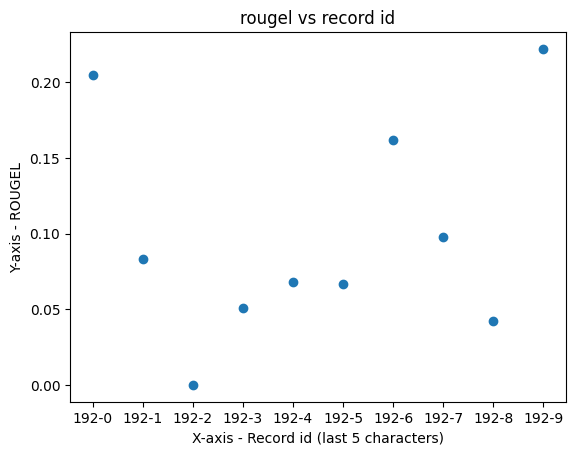

In [30]:
import matplotlib.pyplot as plt

plt.scatter(x, y_rougel, marker='o')

# Adding labels and title
plt.xlabel("X-axis - Record id (last 5 characters)")
plt.ylabel("Y-axis - ROUGEL")
plt.title("rougel vs record id")

# Display the graph
plt.show()

Plot rougelsum metrics against records

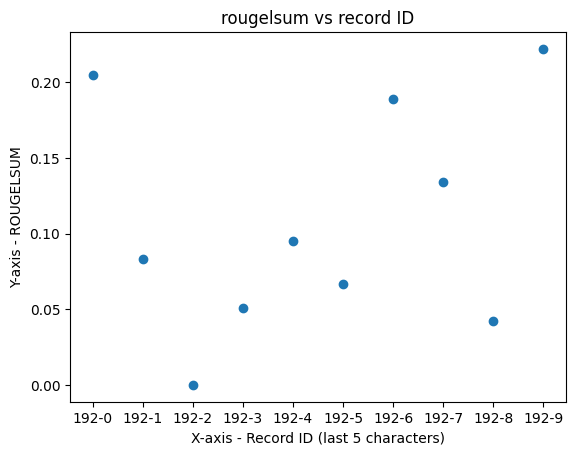

In [31]:
import matplotlib.pyplot as plt

plt.scatter(x, y_rougelsum, marker="o")

# Adding labels and title
plt.xlabel("X-axis - Record ID (last 5 characters)")
plt.ylabel("Y-axis - ROUGELSUM")
plt.title("rougelsum vs record ID")

# Display the graph
plt.show()

# See factsheets information <a name="factsheetsspace"></a>

In [32]:
if not use_cpd:
    factsheets_url = f"{DATAPLATFORM_URL.replace('api.', '')}/wx/prompt-details/{project_pta_id}/factsheet?context=wx&project_id={PROJECT_ID}"
else:
    factsheets_url = f"{CPD_URL}/wx/prompt-details/{project_pta_id}/factsheet?context=wx&project_id={PROJECT_ID}"

print(f"User can navigate to the published facts in project {factsheets_url}")

User can navigate to the published facts in project https://dataplatform.cloud.ibm.com/wx/prompt-details/62601dc6-c2c5-411e-8f15-dbe6e5f87914/factsheet?context=wx&project_id=92a5f3ed-2c64-4039-817c-030404d1f2be


## Congratulations!

You have finished the hands-on lab for IBM Watson OpenScale. You can now navigate to the prompt template asset in your project and click on the Evaluate tab to visualize the results on the UI.